## Introduction

**Abstract:** The main objective of this project is to create a robust system that can effectively identify instances of hate speech within tweets. In this context, hate speech refers to content that displays racist or sexist sentiments. The objective is to develop a classification model capable of distinguishing tweets containing such harmful language from those that don't. This model should be capable of effectively assigning labels to unseen tweets in a provided test dataset based on the presence or absence of hate speech

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", 200)
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Loading the data from the Input Data

In [2]:
# Reading the data from csv
test = pd.read_csv('https://raw.githubusercontent.com/dipika0305/Twitter-Sentiment-Analysis/main/test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/dipika0305/Twitter-Sentiment-Analysis/main/train.csv')

In [3]:
#Viewing the data in Test Dataset
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [4]:
#Viewing the data in Train Dataset
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


## Project Workflow

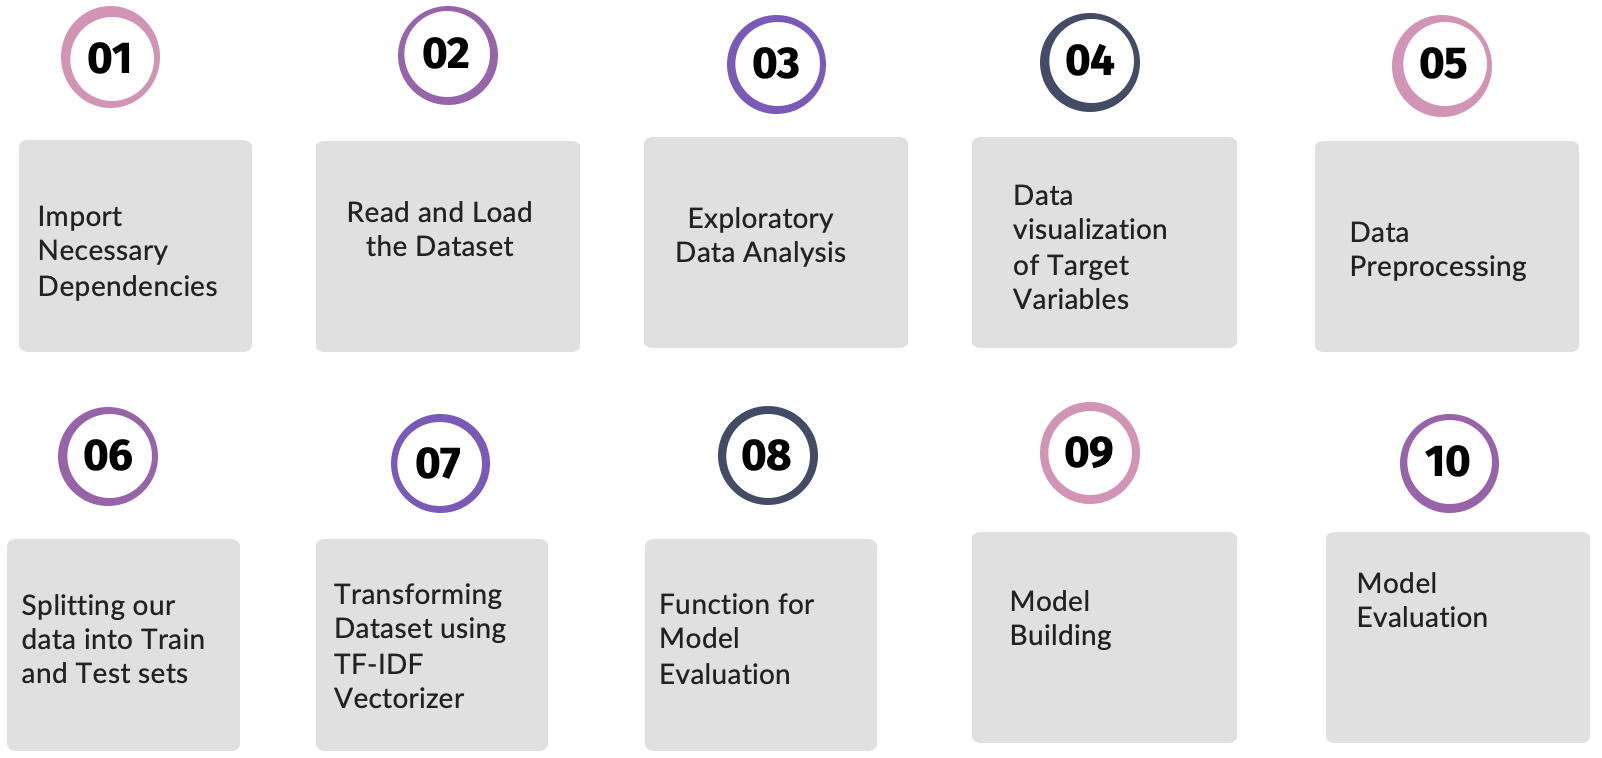

## Understanding the Data

In [5]:
print("Shape of Training Dataset: ", train.shape)
print("Shape of Test Dataset: ", test.shape)

Shape of Training Dataset:  (31962, 3)
Shape of Test Dataset:  (17197, 2)


In [6]:
# Counting the occurrences of each label in the 'label' column of the Train dataset
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
train.tail(5)

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act"
31961,31962,0,thank you @user for you follow


In [8]:
# Extracting the first few rows of the Train dataset where the 'label' column has a value of '0'
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [9]:
# Extracting the first few rows of the Train dataset where the 'label' column has a value of '1'
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


Text(0.5, 1.0, 'Distribution of Tweet Length')

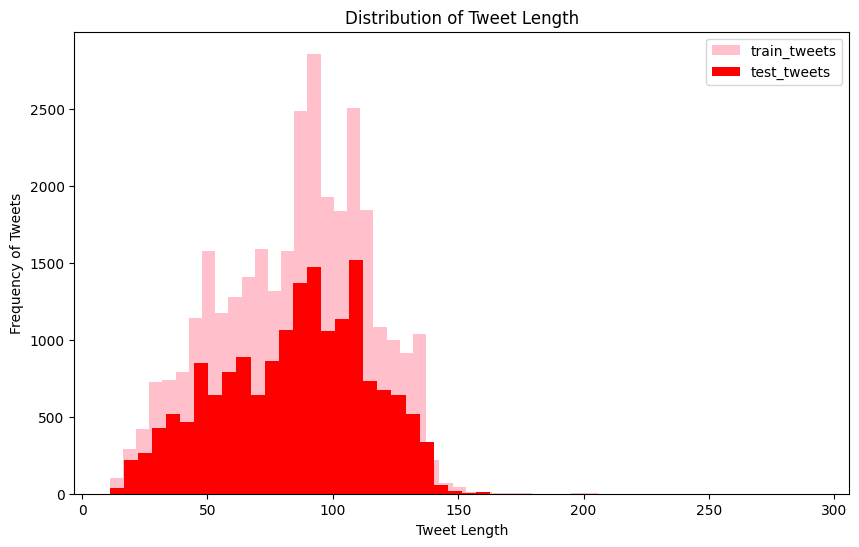

In [10]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.figure(figsize=(10,6))

# Plotting the histograms
plt.hist(length_train, bins=50, label="train_tweets",color = 'pink')
plt.hist(length_test, bins=50, label="test_tweets",color = 'red')

# Adding legend
plt.legend()

# Setting labels for axes
plt.xlabel("Tweet Length")
plt.ylabel("Frequency of Tweets")

# Adding a title
plt.title("Distribution of Tweet Length")

## Data Pre-Processing

Text data's primary drawback is that it is only available in text format (strings). However, in order to complete the work, machine learning algorithms require a specific type of numerical feature vector.

Fundamental preprocessing of text encompasses:

### (a) Data Cleaning

In [11]:
merge = train.append(test, ignore_index=True, sort=False)
merge.shape

(49159, 3)

### (b) Removing unwanted text patterns from the tweets:

In [12]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

### (c) Removing Twitter Handles (@user)

In [13]:
merge['tidy_tweet'] = np.vectorize(remove_pattern)(merge['tweet'], "@[\w]*")
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


### (d) Removing Short Words

In [14]:
merge['tidy_tweet'] = merge['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit can't cause they don't offer wheelchair vans pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation


### (e) Removing Punctuations, Numbers, and Special Characters

In [15]:
merge['tidy_tweet'] = merge['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit can t cause they don t offer wheelchair vans pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time ur
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


### (f) Tokenization

It refers to the procedure of turning a list of tokens, or words that we actually want, from the standard text strings. We can use the Word tokenizer to find the list of words in strings and the Sentence tokenizer to get the list of sentences.

### (g) Text Normalization

Text normalization is the process of transforming text data into a consistent and standardized format, making it easier to analyze and work with.

In [16]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                     [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, can, t, cause, they, don, t, offer, wheelchair, vans, pdx, #disapointed, #getthanked]
2                                                                                          [bihday, your, majesty]
3                                                                             [#model, love, take, with, time, ur]
4                                                                               [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

### (h) Stemming

The act of stemming involves taking inflected (or occasionally derived) words and reducing them to their stem, base, or root form, which is typically a written word form. For instance, the word "stem" would be produced if we stemmed the phrases "Stems," "Stemming," "Stemmed," and "Stemtization".

In [17]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                                        [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, can, t, caus, they, don, t, offer, wheelchair, van, pdx, #disapoint, #getthank]
2                                                                                   [bihday, your, majesti]
3                                                                      [#model, love, take, with, time, ur]
4                                                                              [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

### (i) Transformation

Here we are ddding the tidy tweets back to the main (merge) dataframe.

In [18]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

merge['tidy_tweet'] = tokenized_tweet
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit can t caus they don t offer wheelchair van pdx #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time ur
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


## Visualizing the Data

### Visualizing the tidy tweets


**WordCloud**: An understanding of the prevalent terms used in tweets

Let's examine how evenly distributed the provided sentiments are across the Train dataset. Plotting wordclouds is one method for gaining an insight of the common words used.

A word cloud is a collection of words that collectively have the appearance of a cloud. Words that are used more frequently in the original text are highlighted more prominently by the clouds.


In [19]:
from wordcloud import WordCloud
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='white', colormap='Blues', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

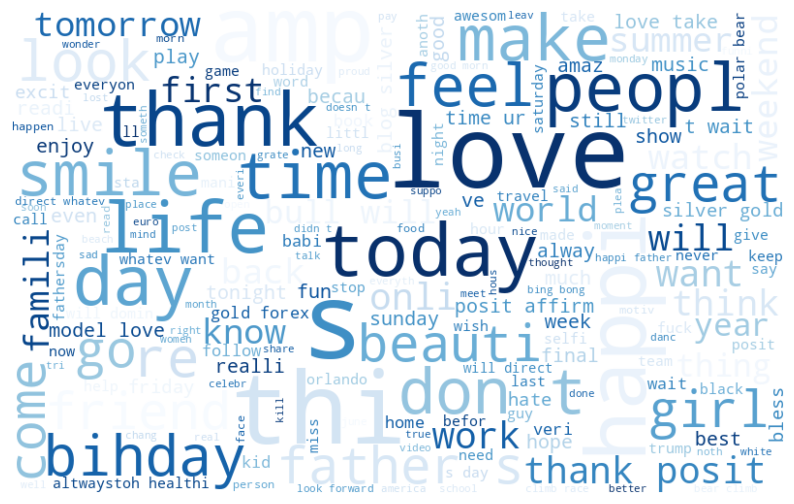

In [20]:
all_words = ' '.join([text for text in merge['tidy_tweet']])
plot_wordCloud(all_words)

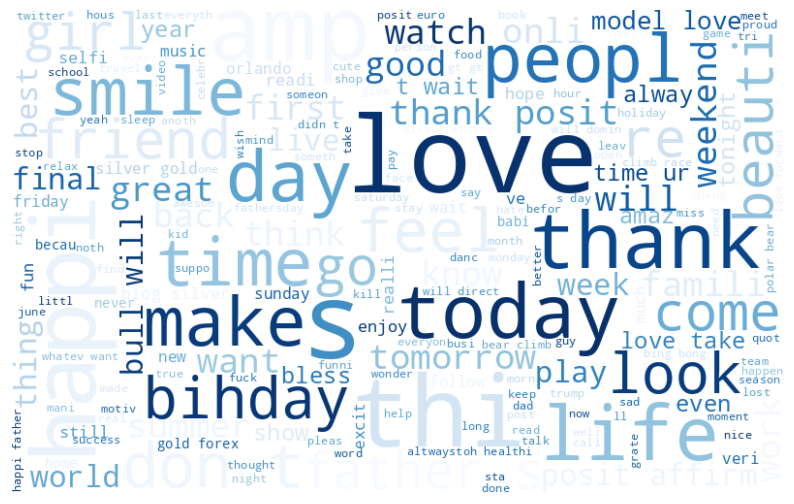

In [21]:
normal_words =' '.join([text for text in merge['tidy_tweet'][merge['label'] == 0]])
plot_wordCloud(normal_words)

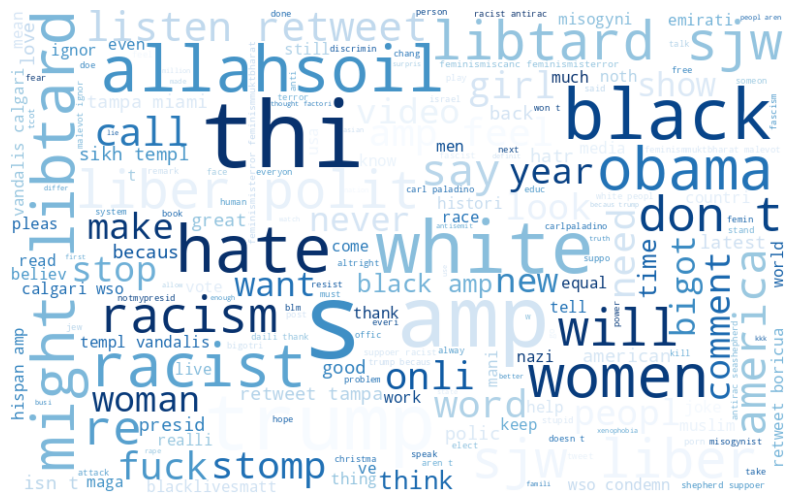

In [22]:
negative_words = ' '.join([text for text in merge['tidy_tweet'][merge['label'] == 1]])
plot_wordCloud(negative_words)

### Hashtag Analysis

In [23]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [24]:
# Extracting hashtags from non racist tweets
HT_regular = hashtag_extract(merge['tidy_tweet'][merge['label'] == 0])

# Extracting hashtags from racist tweets
HT_negative = hashtag_extract(merge['tidy_tweet'][merge['label'] == 1])

# Unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

### Hashtag: Non-racial tweets

Text(0.5, 1.0, 'Top 15 Most Frequent Hashtags in Tweets')

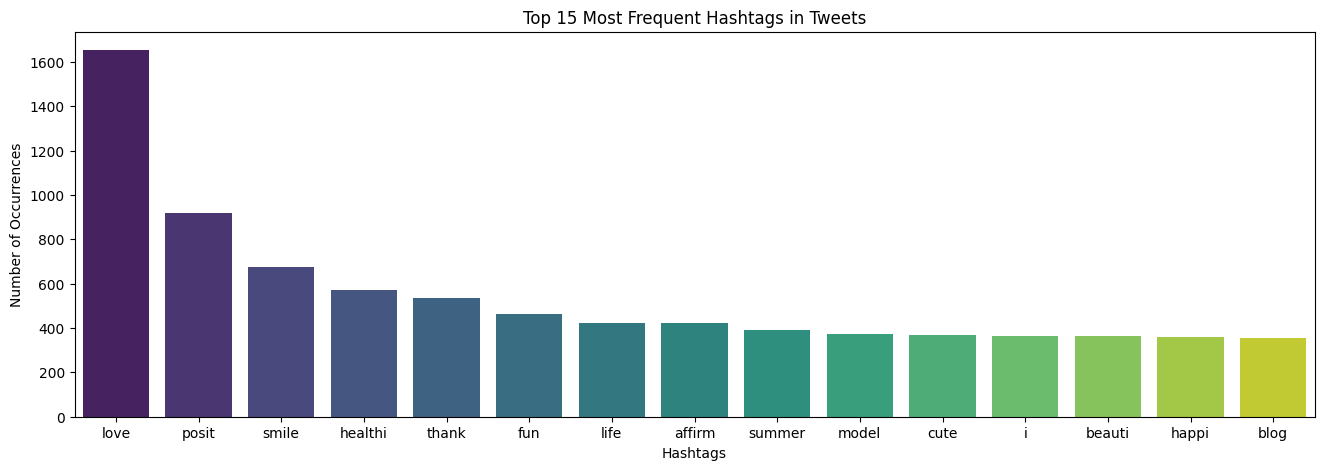

In [25]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# Selecting top 15 most frequent hashtags
d = d.nlargest(columns="Count", n = 15)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", palette="viridis")
ax.set_xlabel("Hashtags")
ax.set_ylabel("Number of Occurrences")
ax.set_title("Top 15 Most Frequent Hashtags in Tweets")

### Hashtag: Racial Tweets

Text(0.5, 1.0, 'Top 15 Most Frequent Hashtags in Tweets')

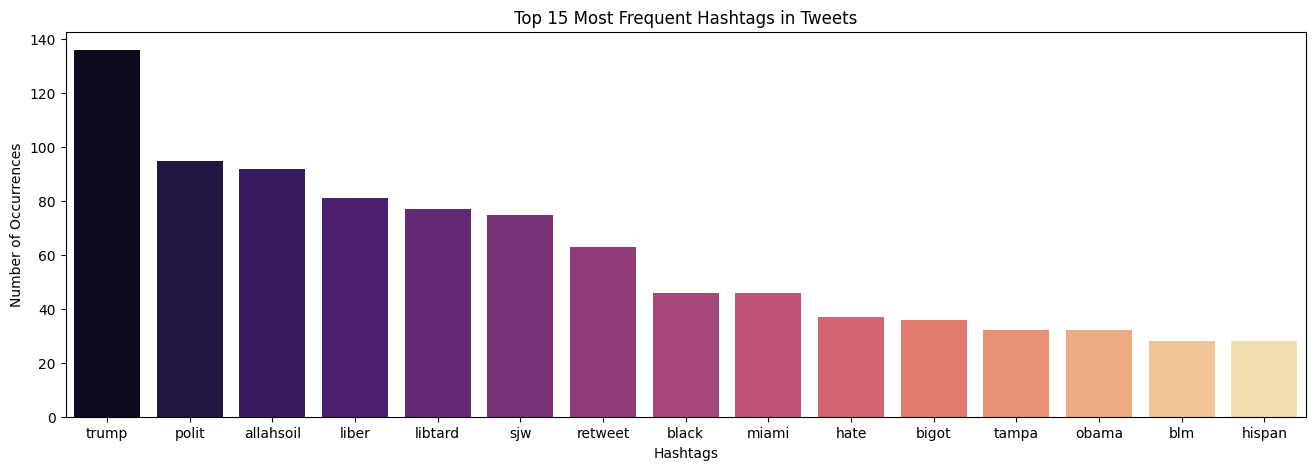

In [26]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 15 most frequent hashtags
e = e.nlargest(columns="Count", n = 15)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count", palette="magma")
ax.set_xlabel("Hashtags")
ax.set_ylabel("Number of Occurrences")
ax.set_title("Top 15 Most Frequent Hashtags in Tweets")

We see that the majority of the positive hashtags express *thanks, love, and pleasure*. The negative hashtags, on the other hand, are connected to particular "*human personalities.*"

## Feature Extraction from Cleaned Tweets

### Bag-of-words

The bag-of-words model is a condensing representation used in information retrieval (IR) and natural language processing (NLP). This paradigm ignores syntax and even word order while maintaining multiplicity and represents a text (such as a sentence or document) as the bag (multiset) of its words.

In [27]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(merge['tidy_tweet'])


### Term Frequency-Inverse Document Frequency (TF-IDF)

Some words occur frequently in a big text corpus yet contain very little useful information. The highly frequent tokens with minimal relevance will significantly influence the low frequency but far more interesting phrases if we directly train a model using the count data. Thus, the word count result needs to be normalized and reweighted.

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(merge['tidy_tweet'])

### Word2Vec Embeddings

Word2vec represents a two-layer neural net designed for text analysis. Its input is a text corpus and its output is a collection of vectors.

In [29]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(merge['tidy_tweet']), epochs=20)

(7161967, 8318980)

In [30]:
model_w2v.wv.most_similar(positive="thanku")

[('unborn', 0.7829484343528748),
 ('do#', 0.7739759683609009),
 ('minni', 0.7716553211212158),
 ('#tvk', 0.7579701542854309),
 ('#viamiano', 0.7548002600669861),
 ('dada', 0.7442063689231873),
 ('abba', 0.7370483875274658),
 ('the#hardwork', 0.733829915523529),
 ('royalorchid', 0.731864333152771),
 ('samuel', 0.7307592630386353)]

In [31]:
model_w2v.wv.most_similar(positive="hate")

[('muzzi', 0.5169859528541565),
 ('heterosexu', 0.5065379738807678),
 ('bigotri', 0.49928852915763855),
 ('jihadi', 0.49783000349998474),
 ('conniv', 0.49455127120018005),
 ('persecut', 0.48750221729278564),
 ('baffl', 0.48344674706459045),
 ('entrench', 0.4794372022151947),
 ('#bullshit', 0.47778192162513733),
 ('inflict', 0.47664010524749756)]

In [32]:
length_of_vector = len(model_w2v.wv['donald'])
print(length_of_vector)

200


Preparing Vectors for Tweets: By averaging the vectors of the words that are present in each tweet, we will use the code below to produce a vector for each tweet.

In [33]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec Feature Set:

In [34]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

In [35]:
tqdm.pandas(desc="progress-bar")

We need to label or tag each tokenized tweet with a distinct ID in order to implement doc2vec. Using Gensim's LabeledSentence() method will enable us to do this.

In [36]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

In [37]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets


Now let's train a doc2vec model. Doc2vec is a generalization of the word2vec technique and an NLP tool for expressing documents as a vector.

In [38]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

100%|██████████| 49159/49159 [00:00<00:00, 4741802.32it/s]


In [39]:
model_d2v.train(labeled_tweets, total_examples= len(merge['tidy_tweet']), epochs=15)

Preparing doc2vec Feature Set:

In [40]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(merge)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

## Building the Model

We'll use the following algorithms to build the models:

1. Random Forest Classifier
2. SVM Classfier
3. XGboost

### Defining Methods to be used for Evaluating the Models

In [41]:
MODEL_ID = []
Accuracy = []
LOG_CV_ERR = []
F1Score = []
def calculate_log_cv_error(logmodel,X_train,y_train):
    ms_errors= cross_val_score(logmodel, X_train, y_train, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

In [42]:
def evaluate_model(logmodel,X_train,X_test,y_train,y_test,predictions):
    log_cv_error = calculate_log_cv_error(logmodel,X_train,y_train)
    print(f'\nClassification Report:\n{classification_report(y_test,predictions)}')
    print('')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test,predictions)}')
    print('')
    print (f'\nAccuracy Score:  {accuracy_score(y_test,predictions)}')
    print("Cross Validation Error: ",log_cv_error)
    logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
    LOG_CV_ERR.append(log_cv_error)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


**CONFUSION MATRIX**

* A confusion matrix is a table that provides a comprehensive view of the performance of a classification model.
* It allows us to understand the relationship between the predicted classes by the model and the actual classes in the dataset.
* In a binary classification scenario (two classes), a confusion matrix consists of four values:

  - True Positives (TP): Instances that are correctly predicted as positive.
  - True Negatives (TN): Instances that are correctly predicted as negative.
  - False Positives (FP): Instances that are incorrectly predicted as positive when they are actually negative.
  - False Negatives (FN): Instances that are incorrectly predicted as negative when they are actually positive.

\\

**F1 SCORE**

* F1 score takes into account both false positives (incorrectly predicted positive instances) and false negatives (incorrectly predicted negative instances).
* It balances the trade-off between precision and recall.
* It's particularly useful when dealing with imbalanced datasets where one class might have significantly more instances than the other.
    
    -	Precision : the proportion of true positive predictions among all positive predictions.

    -	Recall : the proportion of true positive predictions among all actual positive instances

* Mathematically, the F1 score is the harmonic mean of precision and recall:

  $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

\\

**ACCURACY**

* Accuracy, in the context of a model's performance, refers to the proportion of correctly predicted outcomes in relation to the total number of predictions made by the model.
*It's a common metric used to measure the overall correctness of predictions. Mathematically, accuracy is calculated as:

    Accuracy
=
(Number of Correct Predictions/Total Number of Predictions)
×
100

\\

**AREA UNDER THE CURVE**

* The Area Under the Curve (AUC) is a metric used to evaluate the performance of classification models, particularly in the context of Receiver Operating Characteristic (ROC) curves.
* The ROC curve is a graphical representation that shows the trade-off between a model's true positive rate (sensitivity) and its false positive rate as the classification threshold changes.
* A higher AUC value (closer to 1) indicates that the model has better discrimination power, meaning it can better differentiate between the classes. A random classifier would have an AUC value of around 0.5.



### 1. Support Vector Machine

* SVM is a machine learning technique that helps in classifying data points into distinct categories by finding a hyperplane that effectively separates different classes while maximizing the margin between them.
* This hyperplane serves as a decision boundary, aiding the classification process.
* The core principle of SVM is to identify the most relevant data points known as support vectors, which play a crucial role in determining the optimal hyperplane. By focusing on these points, SVM achieves a balance between generalization and avoiding overfitting.
* SVM can be optimized using hyperparameters such as Kernels, Regularization, Gamma, and Margin. SVM works really well with a clear margin of separation and high dimensional spaces

#### Bag-of-Words Features

In [43]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# Splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],
                                                          random_state=42,
                                                          test_size=0.3)

In [44]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5206991720331187


#### TF-IDF Features

In [45]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [46]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5127737226277372


#### Word2Vec Features

In [47]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [48]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6146788990825688



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8905
           1       0.64      0.59      0.61       684

    accuracy                           0.95      9589
   macro avg       0.81      0.78      0.79      9589
weighted avg       0.95      0.95      0.95      9589



Confusion Matrix:
[[8683  222]
 [ 282  402]]


Accuracy Score:  0.9474397747418918
Cross Validation Error:  0.2159630378281257


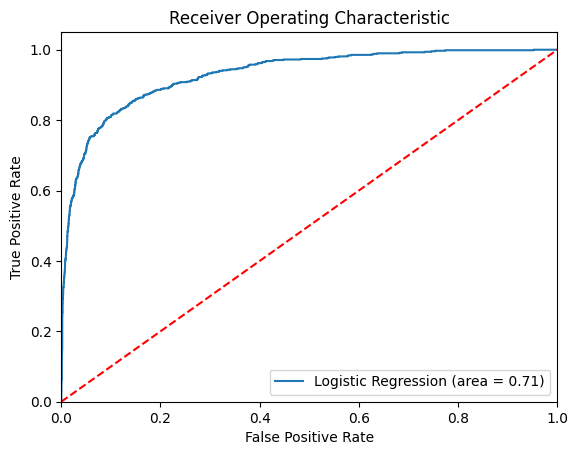

In [49]:
evaluate_model(svc,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Support Vector Classifier')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))

#### Doc2Vec Features

In [50]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [51]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.19585253456221197


#### Hyperparameter Tuning for SVM

Hyperparameter tuning refers to the process of finding the optimal values for the hyperparameters of a machine learning algorithm. Hyperparameters are parameters that are set before the learning process begins, unlike the model's internal parameters, which are learned from the data. Examples of hyperparameters include learning rate, regularization strength, number of trees in a random forest, and depth of decision trees.

Hyperparameter tuning is crucial for several reasons:

1. **Improving Model Performance**: The choice of hyperparameters can significantly impact the performance of a machine learning model. Finding the right values can lead to better accuracy, precision, recall, and other evaluation metrics.

2. **Avoiding Overfitting and Underfitting**: Proper hyperparameter values help in avoiding overfitting (when a model is too complex and fits the training data too closely) and underfitting (when a model is too simple to capture the underlying patterns). Tuning can strike a balance between these two extremes.

3. **Generalization**: A well-tuned model generalizes better to new, unseen data. By finding the optimal hyperparameters, you enhance the model's ability to perform well on new, real-world data.

4. **Efficient Resource Usage**: Hyperparameter tuning can help in optimizing resource usage, such as memory and computation time. It ensures that the model is trained with the right complexity for the given data.

5. **Algorithm Behavior**: Different hyperparameter values can lead to variations in how a model learns. Tuning helps you understand the behavior of the algorithm and how it interacts with your data.

6. **Customization to Data**: Hyperparameters should be tailored to the specific dataset and problem at hand. Tuning allows you to adapt the model to the nuances of your data.

In [52]:
# Defining the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # You can try other kernels like 'poly' or 'sigmoid'
    'probability': [True]
}

# Craeting a list of feature sets and iterate through them
feature_sets = [(xtrain_bow, xvalid_bow), (xtrain_tfidf, xvalid_tfidf),
                (xtrain_w2v, xvalid_w2v), (xtrain_d2v, xvalid_d2v)]

for i, (xtrain, xvalid) in enumerate(feature_sets):
    print(f"### Feature Set {i + 1} ###")

    # Creating an SVM classifier
    svc = SVC()

    # Performing grid search with cross-validation
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1', cv=3)
    grid_search.fit(xtrain, ytrain)

    # Getting the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best F1 Score:", best_score)

    # Training SVM with best parameters on the entire training set
    best_svc = SVC(**best_params)
    best_svc.fit(xtrain, ytrain)

    # Making predictions and evaluate the model
    prediction = best_svc.predict_proba(xvalid)
    prediction_int = prediction[:, 1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    f1 = f1_score(yvalid, prediction_int)
    print("F1 Score:", f1)

    # Appending the results to your lists (MODEL_ID, Accuracy, F1Score)
    MODEL_ID.append('Support Vector Classifier - Feature Set {}'.format(i + 1))
    Accuracy.append(best_svc.score(xvalid, yvalid))
    F1Score.append(f1)


### Feature Set 1 ###
Best Parameters: {'C': 10, 'kernel': 'rbf', 'probability': True}
Best F1 Score: 0.5766369546480474
F1 Score: 0.5770887166236003
### Feature Set 2 ###
Best Parameters: {'C': 10, 'kernel': 'rbf', 'probability': True}
Best F1 Score: 0.5873177038106274
F1 Score: 0.5914529914529916
### Feature Set 3 ###
Best Parameters: {'C': 10, 'kernel': 'rbf', 'probability': True}
Best F1 Score: 0.6915331624144105
F1 Score: 0.6936866718628215
### Feature Set 4 ###
Best Parameters: {'C': 10, 'kernel': 'rbf', 'probability': True}
Best F1 Score: 0.3580092450105494
F1 Score: 0.46166950596252126


### 2. Random Forest

* Random Forest is a machine learning technique that combines multiple decision trees to make accurate predictions.
* Each decision tree is built on different subsets of the data and features, ensuring diversity in the model.
* When making predictions, the outcomes of all individual trees are considered, and the final prediction is determined through a voting or averaging process.

#### Bag-of-Words Features

In [53]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5306451612903226


#### TF-IDF Features

In [54]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.55338904363974


#### Word2Vec Features

In [55]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.4809575625680088



Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8905
           1       0.94      0.32      0.48       684

    accuracy                           0.95      9589
   macro avg       0.95      0.66      0.73      9589
weighted avg       0.95      0.95      0.94      9589



Confusion Matrix:
[[8891   14]
 [ 463  221]]


Accuracy Score:  0.9502555010950047
Cross Validation Error:  0.2180473364951554


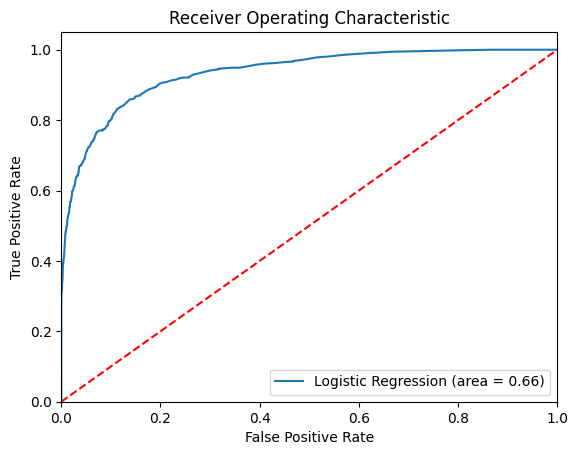

In [56]:
evaluate_model(rf,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction)
MODEL_ID.append('Random Forest CLassifier')
Accuracy.append(accuracy_score(yvalid, prediction))
F1Score.append(f1_score(yvalid, prediction))

#### Doc2Vec Features

In [57]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.056818181818181816


#### Hyperparamter Tuning for Random Forest

In [58]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import f1_score

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [11]
}

# You can create a list of feature sets and iterate through them
feature_sets = [(xtrain_bow, xvalid_bow), (xtrain_tfidf, xvalid_tfidf),
                (xtrain_w2v, xvalid_w2v), (xtrain_d2v, xvalid_d2v)]

for i, (xtrain, xvalid) in enumerate(feature_sets):
    print(f"### Feature Set {i + 1} ###")

    # Create a Random Forest classifier
    rf = RandomForestClassifier()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=3)
    grid_search.fit(xtrain, ytrain)

    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best F1 Score:", best_score)

    # Train Random Forest with best parameters on the entire training set
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(xtrain, ytrain)

    # Make predictions and evaluate the model
    prediction = best_rf.predict(xvalid)
    f1 = f1_score(yvalid, prediction)
    print("F1 Score:", f1)

    # You can append the results to your lists (MODEL_ID, Accuracy, F1Score)
    MODEL_ID.append('Random Forest Classifier - Feature Set {}'.format(i + 1))
    Accuracy.append(best_rf.score(xvalid, yvalid))
    F1Score.append(f1)


### Feature Set 1 ###
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400, 'random_state': 11}
Best F1 Score: 0.5630443911098264
F1 Score: 0.545129579982127
### Feature Set 2 ###
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 11}
Best F1 Score: 0.5585668938038585
F1 Score: 0.5529953917050691
### Feature Set 3 ###
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}
Best F1 Score: 0.4817085831861783
F1 Score: 0.4859002169197396
### Feature Set 4 ###
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 11}
Best F1 Score: 0.04508653132280279
F1 Score: 0.056737588652482275


### 3. XGBoost

Four boosting machine learning algorithms are available:

1. Gradient Boosting Machine (GBM)
2. Extreme Gradient Boosting Machine (XGBM)
3. CatBoost
4. LightGBM

* One method that makes use of the idea of ensemble learning is boosting.
* A boosting technique combines several straightforward models to produce the result. The way that XGBoost functions is by combining the forecasts from various decision trees.
* Decision trees make up the entirety of a gradient boosting machine's weak learners.
* Sequentially constructed trees in XGBoost aim to fix the flaws of earlier trees.

#### Bag-of-Words Features

In [59]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5380434782608696


#### TF-IDF Features

In [60]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)
prediction = xgb.predict(xvalid_tfidf)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5399103139013453


#### Word2Vec Features

In [61]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xvalid_w2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')


F1_Score: 0.6500888099467141



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8905
           1       0.83      0.54      0.65       684

    accuracy                           0.96      9589
   macro avg       0.90      0.76      0.81      9589
weighted avg       0.96      0.96      0.95      9589



Confusion Matrix:
[[8829   76]
 [ 318  366]]


Accuracy Score:  0.9589112524767963
Cross Validation Error:  0.1950714824954202


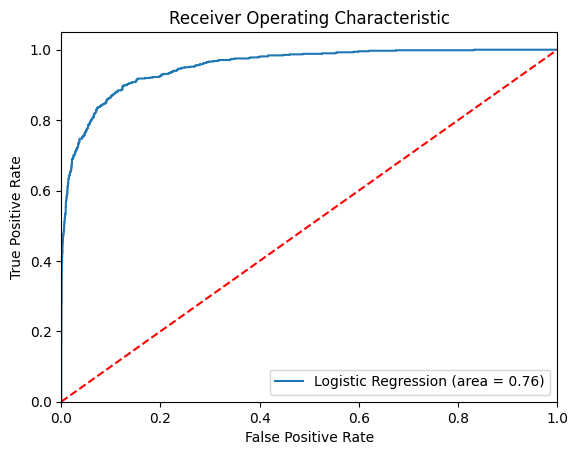

In [62]:
evaluate_model(xgb,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction)
MODEL_ID.append('XGBOOST')
Accuracy.append(accuracy_score(yvalid, prediction))
F1Score.append(f1_score(yvalid, prediction))

#### Doc2Vec Features

In [63]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)
prediction = xgb.predict(xvalid_d2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3433667781493868


### Hyper-Parameters Tuning for Xgboost

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [64]:
import xgboost as xgb
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain)
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid)
dtest = xgb.DMatrix(test_w2v)

In [65]:
# Parameters that we are going to tune
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
}


Let's define a custom evaluation metric to find the F1 score:

In [66]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

The actions listed below will be used to fine-tune the parameters.

1. Selecting a learning rate that is relatively high. At this step, a learning rate of 0.3 is often applied.
2. Setting the learning rate constant while adjusting tree-specific parameters like max_depth, min_child_weight, subsample, and colsample_bytree.
4. Regulating the rate of learning.
5. Adjusting gamma to prevent overfitting.



**Tuning max_depth and min_child_weight:**

In [67]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(5,8)
]

In [68]:
%%capture
max_f1 = 0. # initializing with 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Updating max_depth and min_child_weight parameters and suppressing the grid search verbose using %%capture

In [69]:
params['max_depth'] = 7
params['min_child_weight'] = 5

**Tuning subsample and colsample:**

In [70]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [71]:
%%capture
max_f1 = 0.
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample

    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Updating subsample and colsample_bytree and suppressing the grid search verbose using %%capture

In [72]:
params['subsample'] = .8
params['colsample_bytree'] = .5

**Tuning  learning rate:**

In [73]:
%%capture
max_f1 = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update ETA
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Updating learning rate and suppressing the grid search verbose using %%capture

In [74]:
params['eta'] = .1

**Tuning Gamma value:**

In [75]:
%%capture
max_f1 = 0.
best_params = None
for gamma in range(0,15):
    print("CV with gamma={}".format(gamma/10.))

    # Update ETA
    params['gamma'] = gamma/10.

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = gamma/10.

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Updating gamma value and suppressing the grid search verbose using %%capture

In [76]:
params['gamma'] = .6

In [77]:
params

{'objective': 'binary:logistic',
 'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'colsample': 0.9,
 'gamma': 0.6}

In [78]:
%%capture
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
)

In [79]:
test_pred = xgb_model.predict(dtest)
test['label'] = (test_pred >= 0.3).astype(np.int)


In [92]:
data = {'Model_ID': MODEL_ID, 'F1Score': F1Score, 'Accuracy': Accuracy}
leaderboard = pd.DataFrame(data)
selected_models = ['Support Vector Classifier', 'Random Forest CLassifier', 'XGBOOST']
filtered_leaderboard = leaderboard[leaderboard['Model_ID'].isin(selected_models)]
print(filtered_leaderboard)

                     Model_ID   F1Score  Accuracy
0   Support Vector Classifier  0.614679  0.947440
5    Random Forest CLassifier  0.480958  0.950256
10                    XGBOOST  0.650089  0.958911


We may infer from the above comprehensive study that the **XGBoost** model performs rather well with our data, increasing the **F1 score** and **Accuracy** in comparison to the other machine learning methods applied to our model.

## Conclusion

In this project, we employed multiple training models to make predictions and endeavored to identify the most suitable model for our dataset. Throughout this process, we gained insights into the analysis steps and model training techniques using the NLTK and scikit-learn libraries, which offer user-friendly and advantageous tools. By utilizing distinct vectorization methods such as TF-IDF and Count Vectorizer, we observed variations in the outcomes. For instance, refining the model through the elimination of words with extremely low or high frequencies using TF-IDF led to enhanced outlier filtering and model accuracy.


In evaluating the performance of diverse models like SVM, Random Forest, and XGBoost across a range of extracted features including Bag of Words, Word2Vec, Doc2Vec, and TF-IDF, we considered the F1 score as our evaluation metric. Among these models, our top-performing one proved to be XGBoost, utilizing tuned parameters applied to Word2Vec features, achieving an F1 score of 0.65 and accuracy of 95.89%.

## References

* https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/#h-step-1-import-the-necessary-dependencies

* https://www.jeremyjordan.me/hyperparameter-tuning/

* https://realpython.com/nltk-nlp-python/

* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

* https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

* https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

* https://www.analyticsvidhya.com/blog/2022/02/a-comprehensive-guide-on-hyperparameter-tuning-and-its-techniques/